# Show how storm perturbations affect storm surge.

Read multiple directories containing output from ADCIRC and produced by these NCL scripts
<pre>
/glade/p/work/ahijevyc/ADCIRC/zeta_max.ncl
/glade/p/work/ahijevyc/ADCIRC/perfect_cntl.ncl
/glade/p/work/ahijevyc/ADCIRC/bulge_timeseries.ncl</pre>  
These directories can hold different speed perturbations, veer perturbations, vmax, or rmax perturbations.


In [50]:
# Embed plots in web page. No floating window.
%matplotlib inline
# svg increases resolution when you zoom in (Ctrl-+); png does not.
# Use svg format (scalable vector graphics) for plots in web page, not png
%config InlineBackend.figure_formats=['png']

from IPython.core.debugger import set_trace

### Import python libraries

In [39]:
from matplotlib import dates
import glob, os, urllib, urllib2
from netCDF4 import Dataset
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.markersize': 8})
from mysavfig import mysavfig

###  Define Storm Class and Perturbation Class

In [40]:
import glob, os

class storm:
    # Each storm is initiated with a name and a domain.
    def __init__(self, name, domain):
        self.name = name
        # directory containing all the perturbation subdirectories.
        self.basedir = '/glade/p/work/ahijevyc/ADCIRC/'+name+'/'
        self.domain = domain

def get_xticks(perturbation):
    
    # x-axis may be converted from perturbation magnitude to something else.
    
    # Convert veer perturbations to cross-track distance right of landfall (km)
    # Convert speed perturbations to along-track distance at landfall (km)
    # Keep vmax perturbation (kts)
    # Keep rmax perturbation (%)
    
    stormname = perturbation.storm.name

    if perturbation.name == 'veers':
        if 'IKE' in stormname:
            # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
            pert,dist = zip(*[(-6,-250),(-5,-198),(-4,-157),(-3,-121),(-2,-97),(-1,-49),(-0.5,-24),(0.,0.),
                              (0.5,22),(1.0,44),(2.0,82),(3.0,135),(4.0,146),(5.0,170),(6.0,199)])
        if stormname == 'CHARLEY':
            # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1gKj72PWl8g_0QAOCMZawT2c8QRfDa1DreanUWU4DC74/edit?usp=sharing
            # Spreadsheet lists these from +4.5 to -4.5
            pert = [-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5, 1.5, 2.5, 3.5, 4.5]
            dist = [-343, -289, -153,  -63,  -15, 0,  32,  63, 102, 122, 134]
        

    if perturbation.name == 'speeds':
        if 'IKE' in stormname:
            # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
            pert,dist = zip(*[(-20,-401),(-15,-273),(-10,-173),(-5,-61),(0.,0.),(5,43),(10,130),(15,248)])
        if stormname == 'CHARLEY':
            # From https://docs.google.com/a/ucar.edu/spreadsheets/d/1gKj72PWl8g_0QAOCMZawT2c8QRfDa1DreanUWU4DC74/edit?usp=sharing
            pert = [ -15, -12.5,  -10, -7.5,   -5, -2.5, 0, 2.5,   5, 7.5,  10,  15]
            dist = [-378,  -329, -260, -177, -116,  -35, 0,  94, 163, 220, 275, 348] # km
        

    if perturbation.name == 'vmaxes':
        pert,dist = zip(*[(-7,-28),(7,28)])

        
    if perturbation.name == 'rmaxes':
        # from Kate Fossell's Feb 28 2017 email
        IKErmax = 75.19 # km
        CHARrmax = 36.85 # km
        if stormname == 'IKE':
            pert,dist = zip(*[(-100,-IKErmax),(100,IKErmax)])
        if 'CHAR' in stormname:
            pert,dist = zip(*[(-100,-CHARrmax),(100,CHARrmax)])

            
    xticks = np.interp(perturbation.values, pert, dist)
    return xticks

class perturbations:
    # Initialize a perturbation with a storm instance
    # and a perturbation type (string).
    
    def __init__(self, storm, name, units="", xlabel="", Ithresh='1.00m'):

        # Map to perturbation type to subdirectory name.
        if name == 'veers' :
            pstr = 'veer'
        elif name == 'speeds':
            pstr = 'speed'
        elif name == 'vmaxes':
            pstr = 'vmax_PcAdjust'
        elif name == 'rmaxes':
            pstr = 'rmax'
        else:
            print "Unknown perturbation type", name
            sys.exit(1)
            
        # find all the directories, scrape off numeric part, sort numerically
        dirnames = glob.glob(storm.basedir+pstr+'[+-]*[0-9]')
        values = []
        for i in dirnames:
            j = os.path.basename(i)
            j = j[len(pstr):]
            values.append(float(j))
        x = zip(values,dirnames) # zip together values and dirnames
        x = sorted(x) # sort by values (taking dirnames along for the ride)
        self.values = [i for (i,j) in x]
        self.dirname = [j for (i,j) in x]

        self.storm = storm
        self.name = name
        self.pointA = [None] * len(values)
        self.max_vol         = np.empty(len(values))
        self.max_vol_in_ctrl = np.empty(len(values))
        self.area            = np.empty(len(values))
        self.depth           = np.empty(len(values))
        self.length_scale    = np.empty(len(values))
        self.units = units
        self.maxele = [None] * len(values)
        self.inund  = [None] * len(values)
        self.time   = [None] * len(values)
        self.xlabel = xlabel + ' (' + units + ')'
        self.valuelabels = ['{0:+g}'.format(x)for x in self.values]
        if name == 'rmaxes' or name == 'speeds':
            self.valuelabels = [x+'%' for x in self.valuelabels]
        # no label at zero
        for i, valuelabel in enumerate(self.valuelabels):
            # 'comparing ', valuelabel, ' to zero'
            if self.values[i] == 0:
                self.valuelabels[i] = ''
        self.Ithresh = Ithresh
        self.index = -1
        self.len = len(values)
        # Get title from attributes of length_scale variable in control run.
        ifile=storm.basedir+'control/control.notideFalse_'+Ithresh+'.'+storm.domain+'.timeseries.nc'
        fh = Dataset(ifile, mode='r')
        ls = fh.variables['length_scale']
        self.title = storm.name #
        #(storm.name+' inundation volume\ninundation depth threshold: '+
         #   str(ls.depth_threshold)+ls.depth_threshold_units+'\nlength scale left side: '+
          #  str(ls.left_percentile)+'%; right: '+str(ls.right_percentile)+'%')
        fh.close()

        # Fill in these attributes of perturbations object at time of max Inundation Volume:
        # volume in control zone, length scale, inundation area, average depth
        # Also get max water level field
        for i, pert in enumerate(self.dirname):
            tsfile = glob.glob(pert+'/*.notideFalse_'+Ithresh+'.'+storm.domain+'.timeseries.nc')
            if len(tsfile)!=1 : print "should have "+Ithresh+"."+storm.domain+" timeseries file in "+pert
            fh = Dataset(tsfile[0], mode='r')
            inund = fh.variables['inundation_volume']
            imax = np.argmax(inund[:])
            self.max_vol[i] = inund[imax]
            self.max_vol_in_ctrl[i] = fh.variables['volume_in_ctrl'][imax]
            self.length_scale[i]    = fh.variables['length_scale'][imax]
            self.area[i]            = fh.variables['inundation_area'][imax]
            self.depth[i]           = fh.variables['average_depth'][imax]
            self.inund[i]           = fh.variables['inundation_volume'][:]
            base_date    = dt.datetime.strptime(fh.variables['time'].base_date, "%Y-%m-%d %H:%M:%S %Z")
            self.time[i] = [base_date + dt.timedelta(0,t) for t in fh.variables['time']]
            fh.close()
            mxfile = glob.glob(pert+'/maxele.63.nc')
            if len(mxfile)!=1:
                print "maxele.63.nc not in "+pert
                sys.exit(0)
            print mxfile
            fh = Dataset(mxfile[0], mode='r')
            self.maxele[i] = fh.variables['zeta_max'][:]
            fh.close()

        # Get x-axis tick marks
        self.xticks = get_xticks(self)


            
    # Allow perturbations to be iterated over
    def __iter__(self):
        self.index = -1
        return self
    def next(self):
        if self.index == len(self.values)-1:
            raise StopIteration
        self.index += 1
        return self.values[self.index]
    

### Create storm objects with domains (must have been created by NCL scripts already)

In [41]:
IKE = storm(name='IKE', domain='stride10.-99.0E-87.0E25.0N31.0N')
CHARLEY = storm(name="CHARLEY", domain='stride02.-85.0E-79.0E24.0N30.0N')
CHARIKE = storm(name='CHARIKE', domain='stride02.-99.0E-87.0E25.0N31.0N')

thisstorm = CHARLEY

### Define map_points() for Basemap plots

In [51]:
from mpl_toolkits.basemap import Basemap
import cf_units # Provision of wrapper class to support UDUNITS-2, netcdftime calendar


def map_points(ax, lon, lat, **kwargs):
    m = Basemap(lon_0=-90,lat_0=30,resolution='i',projection='stere',llcrnrlat=np.amin(lat)-1,\
                urcrnrlat=np.amax(lat)+1,llcrnrlon=np.amin(lon)-3,urcrnrlon=np.amax(lon)+3,ax=ax)
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color='aqua')
    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='white',lake_color='aqua')
    # draw parallels and meridians.
    # label parallels on right and top
    # meridians on bottom and left
    parallels = np.arange(0.,81,1.)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,True,False,True])
    meridians = np.arange(10.,351.,2.)
    m.drawmeridians(meridians,labels=[True,True,False,True])
    x, y = m(lon,lat)
    m.plot(x, y, **kwargs)
    return m
    

def forecast_err_box(xmin, xmax, label, **kwargs):
    ax = kwargs['axes']
    # Dont' change the xaxis range
    ax.autoscale(False)
    box = ax.axvspan(xmin, xmax, alpha=0.075, facecolor='red', **kwargs)
    edgecolor = 'red'
    box = ax.axvspan(xmin, xmax, alpha=0.2, facecolor="none", edgecolor=edgecolor, lw=1.8, **kwargs)
    labelL = ax.annotate(s=label, xy=(xmin,0.5), ha="center", va="center", xycoords=('data', 'axes fraction'), 
                         rotation=90, fontsize=12, annotation_clip=True, zorder=1, alpha=0.75, **kwargs)
    labelR = ax.annotate(s=label, xy=(xmax,0.5), ha="center", va="center", xycoords=('data','axes fraction'), 
                         rotation=90, fontsize=12, annotation_clip=True, zorder=1, alpha=0.75, **kwargs)

def forecast_err_boxes(ax, perturbation):

    # clunky way to get nautical miles (multiply knots by hour)
    nm = cf_units.Unit('knot') * cf_units.Unit('hour')

    if perturbation.name == 'veers':
        # list of (hour, nautical miles) tuples to define 2010-2014 cone from 
        # https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
        fhr, radii = zip(*[(12,32),(24,52),(36,71),(48,90),(72,122),(96,170),(120,225)])
        
        # Convert nautical miles to km
        radii = nm.convert(np.array(radii), cf_units.Unit('km'))
        fhrboxes = [12,24,48,72]

    if perturbation.name == 'speeds':
        # list of (hour, km) tuples to define 2010-2014 cone estimated to be more than cross-track error from
        # https://docs.google.com/a/ucar.edu/spreadsheets/d/1_Y9dX2240jMZ1abgZt4E6Td-pODq6k3q8rxVKwz55Us/edit?usp=sharing
        fhr, radii = zip(*[(12,32),(24,52),(36,71),(48,90),(72,122),(96,170),(120,225)])
        # Convert from nm to km
        radii = nm.convert(np.array(radii), cf_units.Unit('km'))
        fhrboxes = [12,24,48,72]

    if perturbation.name == 'vmaxes':
        # list of (hour, knots) tuples from NHC published stats 
        # https://drive.google.com/open?id=0B4GoIuq38OVyLTRhTkxmbE1YZVY1eU5xYlA3RlJWOHlyN3A0
        fhr, radii = zip(*[(24,10),(48,15),(72,20)])
        fhrboxes = fhr
        
    if perturbation.name == 'rmaxes':
        # list of (hour, km) tuples Feb 10 2017 email from Kate Fossell
        # Based on Cangialosi and Landsea (2016)
        fhr, radii = zip(*[(12,37),(24,52),(36,60),(48,63),(72,68)])
        fhrboxes = [12,24,48,72]
        
    try:
        fhr
    except NameError:
        print "no foreast lead time window for", perturbation.name, perturbation.storm.name
        return
    # np.interp(x,xp,fp)
    # x: x-coordinates of interpolated values
    # xp: 1-D seq of floats. the x-coordinates of the data points
    # fp: 1-D seq of floats or complex. The y-coordinates of the data points, same len as xp.
    # Get errors assocated with fboxes list.
    lefts = -np.interp(fhrboxes, fhr, radii)
    rights = np.interp(fhrboxes, fhr, radii)
    for box, left, right in zip(fhrboxes, lefts, rights):
        junk = forecast_err_box(left, right, '%d-hr' % box, axes=ax)
        
def zeroLine(ax):
    #set_trace()
    ax.axvline(x=0, linestyle='dashed', color='black', zorder=1)
    for line in ax.get_lines():
        i0, = np.where(line.get_xdata() == 0)
        if i0:
            ax.axhline(y=line.get_ydata()[i0], linestyle='dashed', color=line.get_color())

### Compare Control to NOAA Stations (IKE only)

In [30]:
if False and thisstorm.name == 'IKE':
    import urllib, csv, re
    import cf_units # Provision of wrapper class to support UDUNITS-2, netcdftime calendar
    
    # NOAA station data come from tidesandcurrents.noaa.gov

    fh = Dataset(thisstorm.basedir+'control/fort.61.nc', mode='r')
    stations = fh.variables['station_name'][:]
    meshlon = fh.variables['x'][:]
    meshlat = fh.variables['y'][:]
    mtime = fh.variables['time']
    base_date = dt.datetime.strptime(mtime.base_date, "%Y-%m-%d %H:%M:%S %Z")
    dt_time = [base_date+dt.timedelta(0,t) for t in mtime]
    zeta = fh.variables['zeta'][:]
    units = fh.variables['zeta'].units
    long_name = fh.variables['zeta'].long_name
    # convert to feet
    newunits = 'feet'
    oldunits = cf_units.Unit(units)
    sf = oldunits.convert(1,cf_units.Unit(newunits))
    units = newunits
    fh.close()

    def turl(id,datum):
        return "http://tidesandcurrents.noaa.gov/api/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&station="+\
            id+"&begin_date=20080911&end_date=20080914&datum="+datum+"&units=english&time_zone=GMT&format=csv"
    
    nstation = (stations.shape)[0]
    for i in range(0,nstation,1):
        id = ''.join(stations[i,:]).strip()
        y = zeta[:,i] * sf
        if y.any():
            print id, " max ADCIRC:", np.ma.max(y),
            fig,ax = plt.subplots(1,2,figsize=(16,4))
            ax[0].set_ylabel(long_name+"\n"+units)
            ax[0].grid()
            ax[0].plot(dt_time,y,label='ADCIRC')
            ax[0].set_title(id)
            ax[0].set_xlim(left=dt.datetime(2008,9,11,0),right=dt.datetime(2008,9,14,12))
            ax[0].xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d %-H'+'Z'))
            ax[0].xaxis.set_major_locator(dates.HourLocator(byhour=[0,12]))
            fig.autofmt_xdate()
            ax[0].set_xlabel(base_date.strftime("%Y"))

            datum = 'NAVD'
            if sum(1 for row in csv.DictReader(urllib2.urlopen(turl(id,datum)))) <= 1:
                print '# rows <=1  trying MSL'
                datum = 'MSL'
            obs_times = []
            waterLevel = []
            waterLevelPreliminary = []
            for row in csv.DictReader(urllib2.urlopen(turl(id,datum))):
                if row.has_key('Date Time') and re.match('[12]\d\d\d-\d\d-\d\d \d\d:\d\d',row['Date Time']):
                    obs_times.append(dt.datetime.strptime(row['Date Time'], "%Y-%m-%d %H:%M"))
                else:
                    break
                if row.has_key(' Quality ') and row[' Water Level'] != '':
                    if row[' Quality '] == 'v':
                        waterLevel.append(row[' Water Level'])
                        waterLevelPreliminary.append(None)
                    else:
                        waterLevel.append(None)
                        waterLevelPreliminary.append(row[' Water Level'])
                else:
                    waterLevel.append(None)
                    waterLevelPreliminary.append(None)
            if any(waterLevel):
                ax[0].plot(obs_times,waterLevel,label='observed ('+datum+')')
            if any(waterLevelPreliminary):
                ax[0].plot(obs_times,waterLevelPreliminary,label='observed ('+datum+')\npreliminary',alpha=0.5)
            ax[0].legend(loc='best')
            map_points(ax[1],meshlon[i],meshlat[i], markeredgewidth=2,linewidth=0,marker='x')


### Compare control to USGS Sensors (IKE only)

In [31]:
if False and thisstorm.name == 'IKE':
    # USGS stations in Open-File Report 2008-1365
    # Monitoring Inland Storm Surge and Flooding from Hurricane Ike in Texas and Louisiana, September 2008
    # By Jeffery W. East, Michael J. Turco, and Robert R. Mason, Jr.
    stations =[
    ["SSS-TX-BRA-001", "Brazoria", 29.21194, -95.20833, "surge"],
    ["SSS-TX-BRA-002", "Brazoria", 29.08472, -95.28806, "surge"],
    ["SSS-TX-BRA-004", "Brazoria", 28.86833, -95.44861, "surge"],
    ["SSS-TX-BRA-005", "Brazoria", 28.94944, -95.55556, "riverine"],
    ["SSS-TX-BRA-006", "Brazoria", 28.86667, -95.58722, "surge"],
    ["SSS-TX-BRA-007", "Brazoria", 29.28667, -95.13139, "riverine"],
    ["SSS-TX-BRA-008", "Brazoria", 29.03556, -95.39889, "surge"],
    ["SSS-TX-BRA-009", "Brazoria", 29.01306, -95.32972, "surge"],
    ["SSS-TX-BRA-010", "Brazoria", 29.33639, -95.28417, "riverine"],
    ["SSS-TX-BRA-011", "Brazoria", 29.29667, -95.35667, "riverine"],
    ["SSS-TX-CAL-001", "Calhoun", 28.40639, -96.71167, "surge"],
    ["SSS-TX-CAL-002", "Calhoun", 28.44444, -96.40250, "surge"],
    ["SSS-TX-CAL-003", "Calhoun", 28.61917, -96.61972, "surge"],
    ["SSS-TX-CAL-004", "Calhoun", 28.66056, -96.41167, "surge"],
    ["SSS-TX-CAL-005", "Calhoun", 28.64139, -96.32333, "surge"],
    ["SSS-TX-CHA-003", "Chambers", 29.60417, -94.67528, "surge"],
    ["SSS-TX-CHA-004", "Chambers", 29.77278, -94.68694, "surge"],
    ["SSS-TX-GAL-001", "Galveston", 29.45139, -94.63417, "beach/wave"],
    ["SSS-TX-GAL-002", "Galveston", 29.46583, -94.64806, "surge"],
    ["SSS-TX-GAL-005", "Galveston", 29.59444, -94.39028, "surge"],
    ["SSS-TX-GAL-008", "Galveston", 29.33444, -94.75111, "beach/wave"],
    ["SSS-TX-GAL-010", "Galveston", 29.23806, -94.87778, "beach/wave"],
    ["SSS-TX-GAL-011", "Galveston", 29.22083, -94.94472, "surge"],
    ["SSS-TX-GAL-015", "Galveston", 29.08611, -95.11722, "beach/wave"],
    ["SSS-TX-GAL-016", "Galveston", 29.30389, -94.90528, "surge"],
    ["SSS-TX-GAL-018", "Galveston", 29.35583, -95.04000, "surge"],
    ["SSS-TX-GAL-019", "Galveston", 29.50639, -94.95778, "surge"],
    ["SSS-TX-GAL-020", "Galveston", 29.45667, -95.04778, "riverine"],
    ["SSS-TX-GAL-021", "Galveston", 29.51333, -95.10389, "riverine"],
    ["SSS-TX-GAL-022", "Galveston", 29.55167, -95.02472, "surge"],
    ["SSS-TX-HAR-002", "Harris", 29.62028, -94.99889, "surge_sensor_psige"],
    ["SSS-TX-HAR-003", "Harris", 29.59194, -95.12833, "surge"],
    ["SSS-TX-HAR-004", "Harris", 29.71306, -94.99333, "surge"],
    ["SSS-TX-JEF-001", "Jefferson", 29.68444, -94.19278, "surge"],
    ["SSS-TX-JEF-002", "Jefferson", 29.67500, -94.04361, "beach/wave"],
    ["SSS-TX-JEF-004", "Jefferson", 29.71028, -94.11639, "surge"],
    ["SSS-TX-JEF-005", "Jefferson", 29.69694, -94.09833, "surge"],
    ["SSS-TX-JEF-006", "Jefferson", 29.71111, -93.86000, "surge"],
    ["SSS-TX-JEF-007", "Jefferson", 29.77389, -93.94250, "surge"],
    ["SSS-TX-JEF-008", "Jefferson", 29.76472, -93.89778, "surge"],
    ["SSS-TX-JEF-009", "Jefferson", 29.66265, -94.08835, "beach/wave"],
    ["SSS-TX-MAT-001", "Matagorda", 28.72056, -96.27389, "surge"],
    ["SSS-TX-MAT-002", "Matagorda", 28.78639, -96.15028, "surge"],
    ["SSS-TX-MAT-003", "Matagorda", 28.78750, -95.99583, "riverine"],
    ["SSS-TX-MAT-004", "Matagorda", 28.83889, -95.85278, "riverine"],
    ["SSS-TX-MAT-005", "Matagorda", 28.60056, -95.97806, "beach/wave"],
    ["SSS-TX-MAT-006", "Matagorda", 28.68306, -95.97556, "riverine"],
    ["SSS-TX-MAT-007", "Matagorda", 28.61139, -96.21528, "surge"],
    ["SSS-TX-MAT-008", "Matagorda", 28.76417, -95.62694, "beach/wave"],
    ["SSS-TX-MAT-009", "Matagorda", 28.77056, -95.61667, "surge"],
    ["SSS-TX-MAT-010", "Matagorda", 28.83639, -95.66833, "riverine"],
    ["SSS-LA-CAM-001", "Cameron", 29.75028, -93.66361, "surge"],
    ["SSS-LA-CAM-002", "Cameron", 29.76194, -93.58250, "surge"],
    ["SSS-LA-CAM-003", "Cameron", 29.80417, -93.34889, "surge"],
    ["SSS-LA-CAM-010", "Cameron", 29.78611, -93.11500, "surge"],
    ["SSS-LA-CAM-011", "Cameron", 29.87056, -93.07972, "surge"],
    ["SSS-LA-CAM-012", "Cameron", 29.77056, -93.01444, "surge"],
    ["SSS-LA-VER-006", "Vermillion", 29.64111, -92.42694, "surge"],
    ["SSS-LA-VER-007", "Vermillion", 29.60028, -92.34167, "surge"]
    ]


    nc_file = thisstorm.basedir+'control/fort.63.nc'
    print nc_file
    fh = Dataset(nc_file, mode='r')
    meshlat=fh.variables['y'][:]
    meshlon=fh.variables['x'][:]
    mtime=fh.variables['time']
    zeta=fh.variables['zeta'][:]
    base_date = dt.datetime.strptime(mtime.base_date, "%Y-%m-%d %H:%M:%S %Z")
    dt_time = [base_date+dt.timedelta(0,t) for t in mtime]

    units = fh.variables['zeta'].units
    long_name = fh.variables['zeta'].long_name
    fh.close()

    # get scale factor for conversion to feet
    newunits = 'feet'
    oldunits = cf_units.Unit(units)
    sf = oldunits.convert(1,cf_units.Unit(newunits))
    units = newunits

    for station in stations:
        site = station[0]
        lat = station[2]
        lon = station[3]
        gtype = station[4]
        # Find closest node in fort.63.nc
        dlat = meshlat - lat
        dlon = meshlon - lon
        dist = np.sqrt(dlat**2+dlon**2)
        i = np.argmin(dist)
        y = zeta[:,i] * sf
        if y.any():
            fig,ax = plt.subplots(1,2,figsize=(16,4))
            ax[0].set_ylabel(long_name+"\n"+units)
            ax[0].grid()
            ax[0].plot(dt_time,y,label='ADCIRC')
            ax[0].set_title(site+"("+gtype+")")
            ax[0].set_xlim(left=dt.datetime(2008,9,11,12),right=dt.datetime(2008,9,14,6))
            ax[0].xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d %-H'+'Z'))
            ax[0].xaxis.set_major_locator(dates.HourLocator(byhour=[0,12]))
            fig.autofmt_xdate()
            ax[0].set_xlabel(base_date.strftime("%Y"))

            link = "http://pubs.usgs.gov/of/2008/1365/downloads/ike_"+site+".txt"
            obs = np.genfromtxt(link,names=True,dtype=None,skip_header=28)
            obs_times = []
            elevations = []
            for o in obs:
                (date, time, elevation, surge_sensor_psi, nearest_barometric_sensor_psi, temp_from_surge_sensor,
                temp_from_barometric_sensor, bad_psi_from_surge_sensor,bad_psi_from_barometric_sensor,
                bad_temp_from_surge_sensor, bad_temp_from_barometric_sensor) = o
                obs_times.append(dt.datetime.strptime(date+time, "%m-%d-%Y%H:%M")+dt.timedelta(hours=5)) # CDT time zone
                elevations.append(elevation)
            ax[0].plot(obs_times,elevations,label='observed')
            ax[0].legend(loc='best')
            map_points(ax[1],meshlon[i],meshlat[i], markeredgewidth=2, marker='x',linewidth=0)



## Create Perturbations Objects

In [32]:
import re

# thisstorm must be defined earlier.

Ithresh = '1.00m'

#  veer perturbations
deg_symbol = u'\N{DEGREE SIGN}'
veers = perturbations(thisstorm, name='veers', units='km', xlabel='Distance from control at landfall',Ithresh = Ithresh)

#  speed perturbations
speeds = perturbations(thisstorm, name='speeds', units='km', xlabel="Distance from control at landfall", Ithresh = Ithresh)

#  vmax perturbations
vmaxes = perturbations(thisstorm, name='vmaxes', units = "kts",
                       xlabel = "Vmax change at 3 days (landfall)",Ithresh = Ithresh)

#  rmax perturbations
rmaxes = perturbations(thisstorm, name='rmaxes', units = "km", 
                       xlabel="Difference in maximum radius of 34-kt isotach at landfall", Ithresh = Ithresh)

# IKE (could be put alongside CHARLEY)
#IKEveers = perturbations(IKE, name='veers', Ithresh = Ithresh)


['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer-4.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer-3.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer-2.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer-1.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer-0.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+0/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+0.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+1.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+2.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+3.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/veer+4.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/speed-15/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/speed-12.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/speed-10/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY/speed-7.5/maxele.63.nc']
['/glade/p/work/ahijevyc/ADCIRC/CHARLEY

#### Grab individual nodes to illustrate noisiness. The indices of these nodes are hard-coded and must have been determined earlier.

In [33]:

A = [0, 64738 ,112521, 118019 ]
if thisstorm.name == 'IKE' or thisstorm.name == 'CHARIKE': # A is a list of nodes that experience large inundation.
    A = [82267,81635,384783,152844,152987,374075,355075,285018,285019,152899,414206,348971]
    A = [81635, 152987,374075]
    A = [int(i/10) for i in [109073,152899, 440403]]
    
# Get lat/lon of nodes in list A.
#tried to get lat and lon of points A but point As were drawn from 
#perfectmodel, which doesn't necessary have the same domain/stride.
ifile=thisstorm.basedir+'control/fort.63.'+thisstorm.domain+'.nc'
print "opening ", ifile, " to find A points ", A
fh = Dataset(ifile, mode='r')
#print ifile, fh
lon = fh.variables['x'][A]
lat = fh.variables['y'][A]
fh.close()

opening  /glade/p/work/ahijevyc/ADCIRC/CHARLEY/control/fort.63.stride02.-85.0E-79.0E24.0N30.0N.nc  to find A points  [0, 64738, 112521, 118019]


### Time Series of Inundation Volume

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_timeseries.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_timeseries.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_timeseries.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_timeseries.png dpi=300


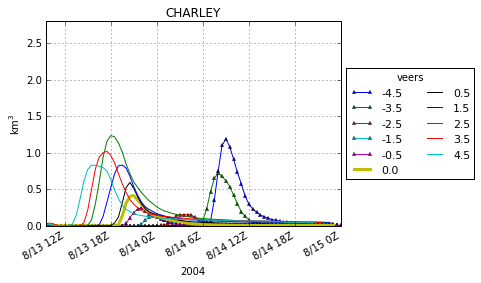

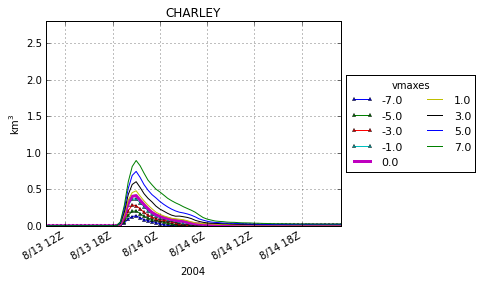

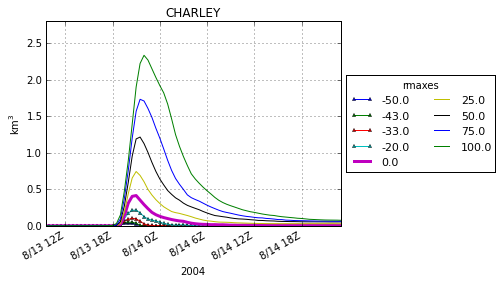

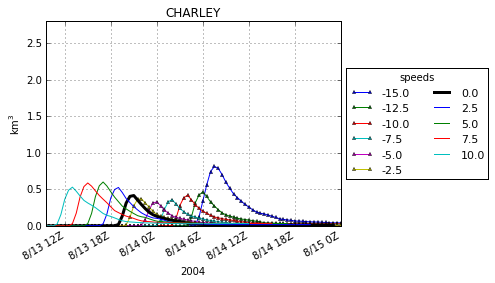

In [35]:
import sys

for perturbation in [veers, vmaxes, rmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    fig, ax = plt.subplots(figsize=(7,4))
    plt.title(perturbation.title)
    plt.tight_layout(rect=(0.02,0.0,0.7,1.))
    #print perturbation.values, perturbation.name, perturbation.dirname
    vdirs = perturbation.dirname
    for i, pert in enumerate(perturbation):
        thick = 3 if float(pert) == 0 else 1
        plt.plot(perturbation.time[i],perturbation.inund[i],label=pert,linewidth=thick,marker='^'if float(pert)<0 else '',markersize=3)

    units = '$\mathregular{km^3}$'
    plt.ylabel(units)

    plt.grid()
    ax.set_ylim(0,2.8)
    if perturbation.storm.name == 'IKE': ax.set_ylim(0,30.)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%-m/%-d %-H'+'Z'))
    ax.xaxis.set_major_locator(dates.HourLocator(byhour=[0,6,12,18]))
    fig.autofmt_xdate()
    plt.xlabel(perturbation.time[0][0].strftime("%Y"))
    
    # put legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title=perturbation.name, ncol=2, fontsize=11)
    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_timeseries.png',dpi=300)



### Maximum water level percentiles

In [36]:
thisstorm.name

'CHARLEY'

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_maxele.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_maxele.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_maxele.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_maxele.png dpi=300


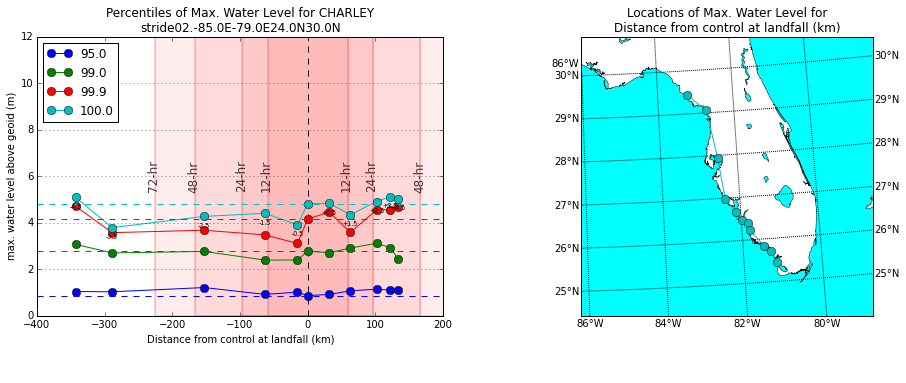

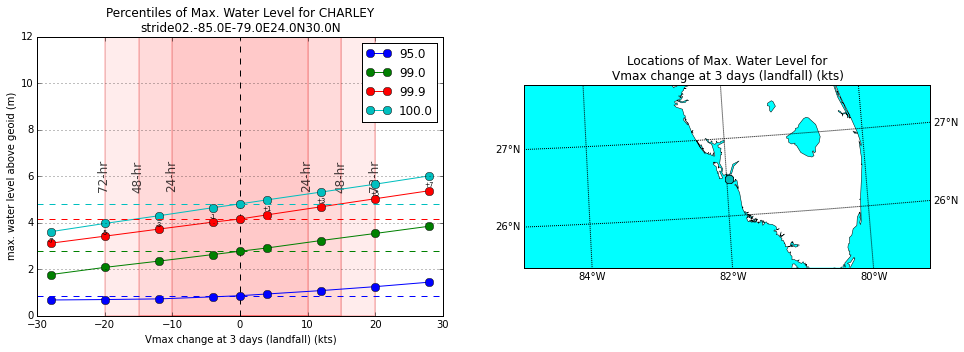

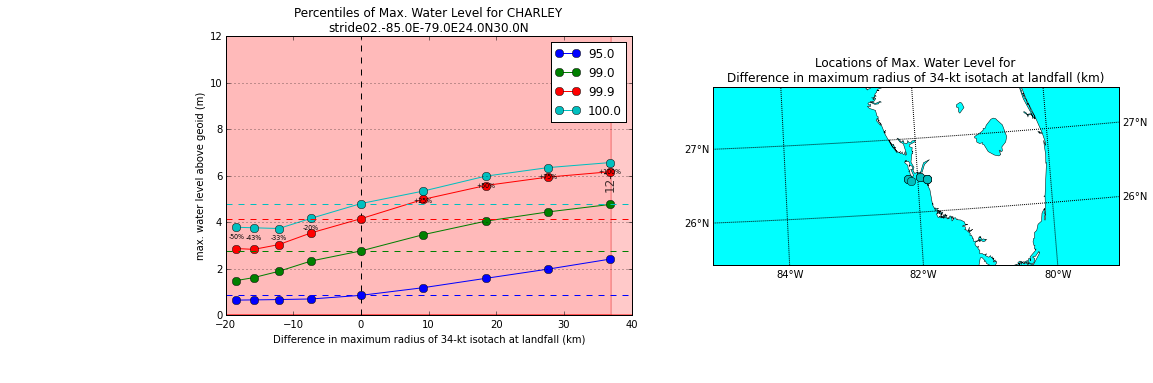

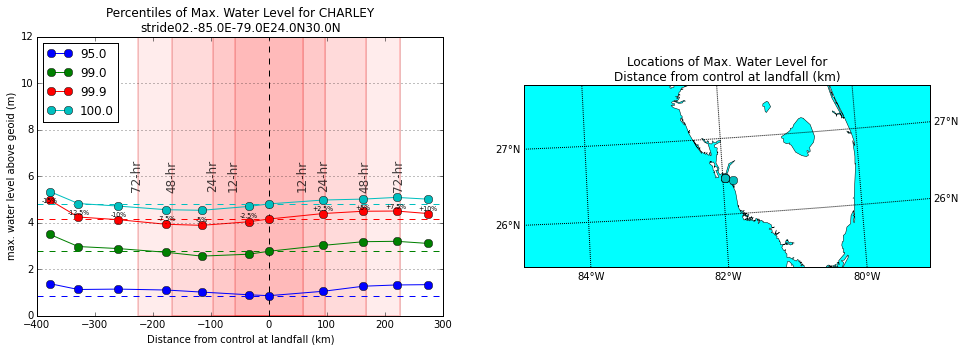

In [52]:
def annotate_pts(perturbation, line):
    for label, xypoints in zip(perturbation.valuelabels, line.get_xydata()):
        line.axes.annotate(label, xy=xypoints, textcoords='offset points', xytext=(0,-6), ha='center', va='top', fontsize=6.3)


def get_bounds(domain):
    #if stormname == 'CHARIKE': domain = 'stride02.-99.0E-87.0E25.0N31.0N'
    #if stormname == 'IKE': domain = 'stride10.-99.0E-87.0E25.0N31.0N'
    #if stormname == 'CHARLEY': domain = 'stride02.-85.0E-79.0E24.0N30.0N'
    words =  domain.split('.')
    stride = words[0]
    lonmin = float(words[1]+'.'+words[2][0:1])
    lonmax = float(words[2][2:]+'.'+words[3][0:1])
    latmin = float(words[3][2:]+'.'+words[4][0:1])
    latmax = float(words[4][2:]+'.'+words[5][0:1])
    return lonmin, lonmax, latmin, latmax

lonmin, lonmax, latmin, latmax = get_bounds(thisstorm.domain)

fh = Dataset(thisstorm.basedir+'control/maxele.63.nc', mode='r')
meshlon = fh.variables['x'][:]
meshlat = fh.variables['y'][:]
fh.close()
ibox = (meshlon >= lonmin) & (meshlon <= lonmax) & (meshlat >= latmin) & (meshlat <= latmax)
meshlon = meshlon[ibox]
meshlat = meshlat[ibox]
for perturbation in [veers, vmaxes, rmaxes, speeds]:

    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue
    fig, ax = plt.subplots(1,2,figsize=(16,5))
    ps = np.array([95,99,99.9,100])
    for p in ps:
        maxele = []
        for i, v in enumerate(perturbation):
            maxele.append(np.percentile(perturbation.maxele[i][ibox],p))
        # Used to plot perturbation.values on x-axis. Changed Feb 28, 2017.
        line, = ax[0].plot(perturbation.xticks,maxele,marker='o',label='%.1f'%p)
    annotate_pts(perturbation, line)
        
    imaxs = []
    for i, v in enumerate(perturbation):
        t = np.argmax(perturbation.maxele[i][ibox])
        imaxs.append(t)
                
    ax[0].set_ylabel('max. water level above geoid (m)')
    ax[0].set_title("Percentiles of Max. Water Level for "+thisstorm.name+"\n"+thisstorm.domain)
    ax[0].yaxis.grid()
    ax[0].set_ylim(0,12)
    legend = ax[0].legend(loc='best', fontsize=12)
    ax[0].set_xlabel(perturbation.xlabel)
    zeroLine(ax[0])
    forecast_err_boxes(ax[0],perturbation)

    m = map_points(ax[1], meshlon[imaxs], meshlat[imaxs], marker='o', color=line.get_color())
    ax[1].set_title('Locations of Max. Water Level for\n'+perturbation.xlabel)
    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_maxele.png',dpi=300)

### Length Scale

<a href="https://drive.google.com/open?id=1n58sZmEkW0J1YR9DRvasOQwQpp2Ojwvm0fI3VBQTk_k">Google Doc about length scale</a>

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_length_scale.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_length_scale.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_length_scale.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_length_scale.png dpi=300


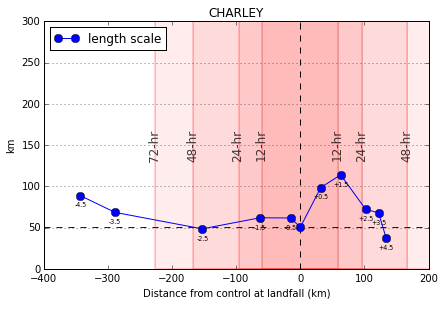

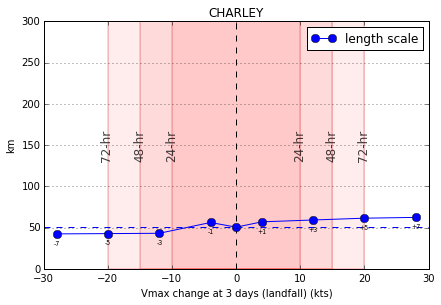

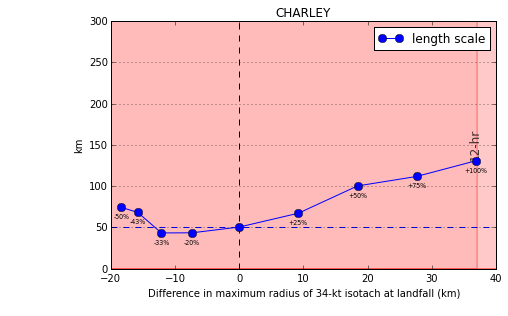

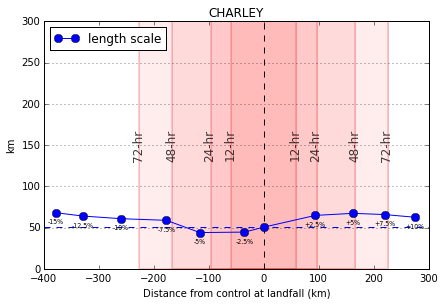

In [53]:

for perturbation in [veers, vmaxes, rmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    fig, ax = plt.subplots()
    plt.tight_layout()
    thisline, = plt.plot(perturbation.xticks,perturbation.length_scale,marker='o',label='length scale')
    annotate_pts(perturbation, thisline)
    plt.ylabel('km')
    ax.set_ylim(0,300)
    if perturbation.storm.name == 'IKE': ax.set_ylim(0,650)
    plt.title(perturbation.title)
    ax.yaxis.grid()
    legend = plt.legend(loc='best', fontsize=12)
    plt.xlabel(perturbation.xlabel)
    zeroLine(ax)
    forecast_err_boxes(ax, perturbation)


    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_length_scale.png',dpi=300)

### Area of Inundation Zone

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_area.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_area.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_area.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_area.png dpi=300


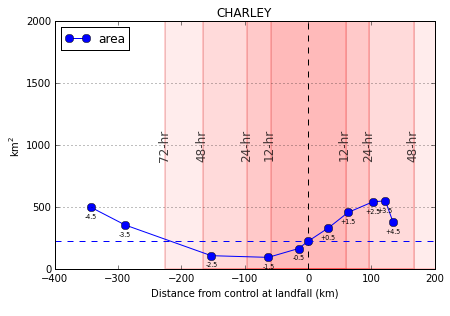

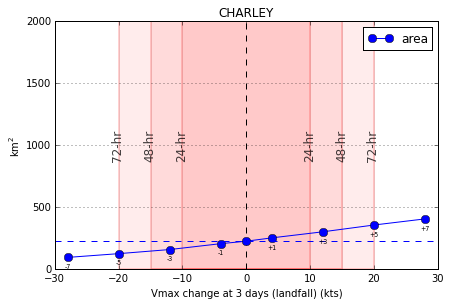

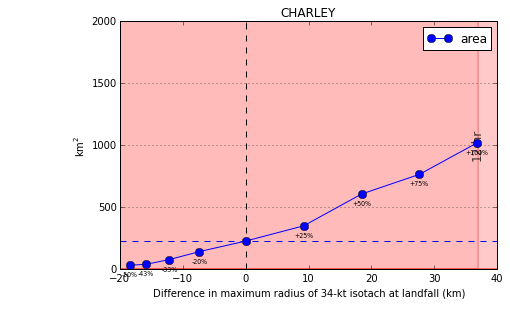

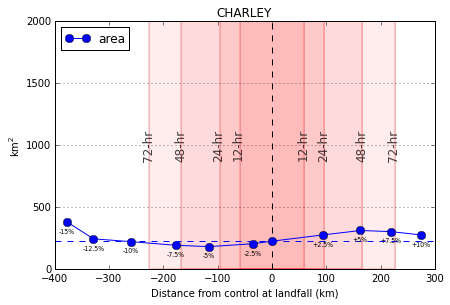

In [54]:
for perturbation in [veers, vmaxes, rmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    fig, ax = plt.subplots()
    # use comma after thisline to "un-list" the one-item list of line objects
    thisline, = plt.plot(perturbation.xticks,perturbation.area,marker='o',label='area')
    annotate_pts(perturbation, thisline)
    plt.tight_layout()
    plt.ylabel('$\mathregular{km^2}$')
    plt.title(perturbation.title)
    ax.yaxis.grid()
    ax.set_ylim(0,2000)
    if perturbation.storm.name == 'IKE': ax.set_ylim(0,18000)
    legend = plt.legend(loc='best', fontsize=12)
    plt.xlabel(perturbation.xlabel)
    zeroLine(ax)
    forecast_err_boxes(ax, perturbation)

    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_area.png',dpi=300)

### Average Depth in Inundation Zone

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_depth.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_depth.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_depth.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_depth.png dpi=300


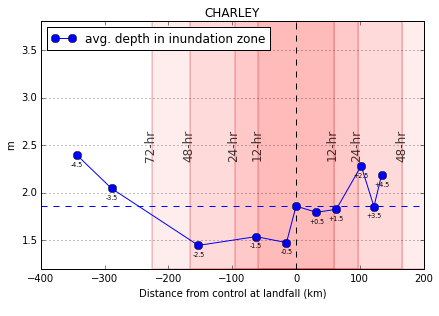

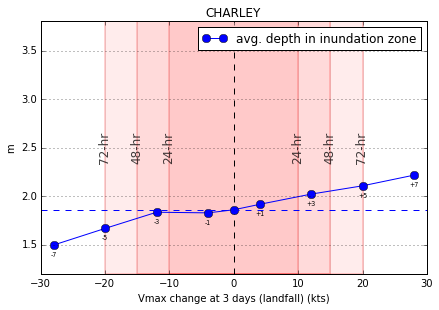

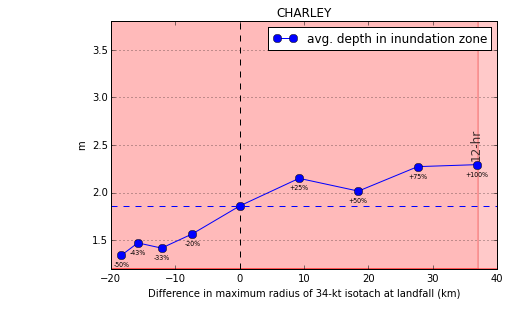

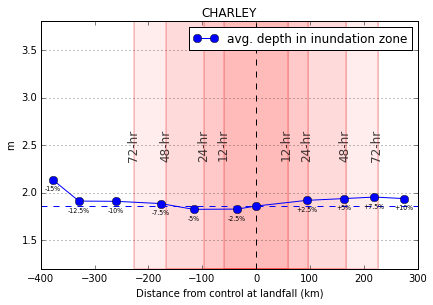

In [55]:
for perturbation in [veers, vmaxes, rmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    fig, ax = plt.subplots()
    thisline, = plt.plot(perturbation.xticks,perturbation.depth,marker='o',label='avg. depth in inundation zone')
    annotate_pts(perturbation, thisline)
    plt.tight_layout()
    plt.ylabel('$\mathregular{m}$')
    plt.title(perturbation.title)
    ax.yaxis.grid()
    ax.set_ylim(1.2,3.8)
    legend = plt.legend(loc='best', fontsize=12)
    plt.xlabel(perturbation.xlabel)
    zeroLine(ax)
    forecast_err_boxes(ax, perturbation)

    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_depth.png',dpi=300)

### Pearson correlation coefficient squared, Bias, Root Mean Squared Error

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_stats.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_stats.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_stats.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_stats.png dpi=300


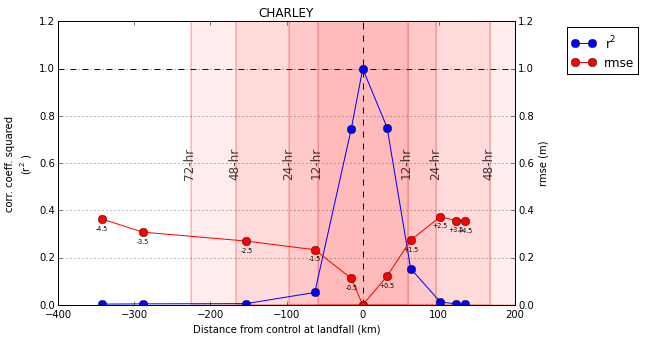

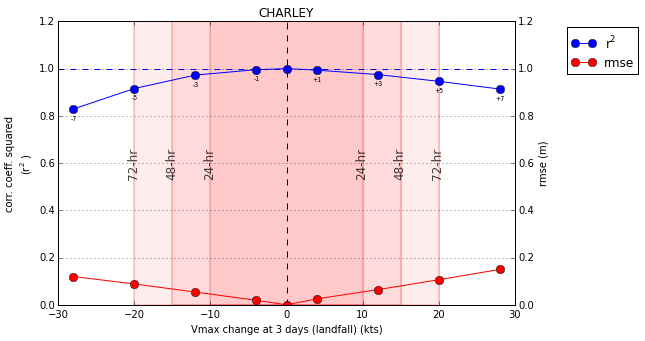

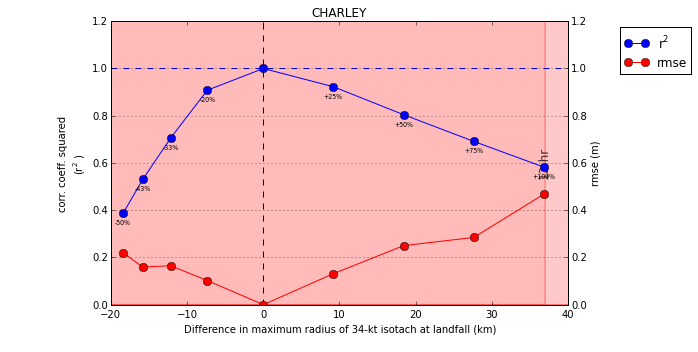

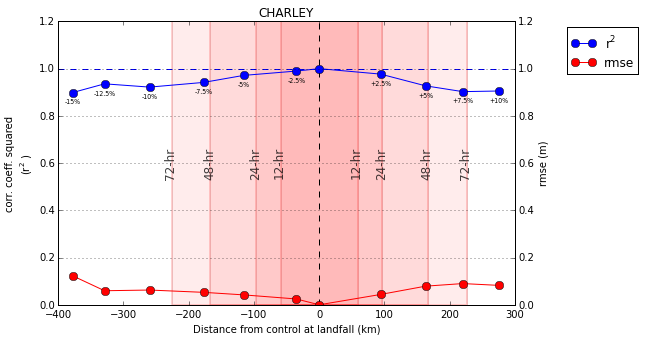

In [56]:
for perturbation in [veers, vmaxes, rmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    r2 = []
    bias = []
    rmse = []
    fig, ax = plt.subplots(figsize=(7,4.5))
    plt.tight_layout()

    for i, pdir in enumerate(perturbation.dirname):
        for nc_file in glob.glob(pdir+'/*.perfectmodel.zoom1.nc'):
            #print 'reading '+nc_file
            fh = Dataset(nc_file, mode='r')
            r2.append(fh.variables['rc_tmp'].getncattr('r2'))
            yave = fh.variables['rc'].getncattr('yave')
            xave = fh.variables['rc'].getncattr('xave')
            bias.append(yave/xave)
            obs = fh.variables['obs'][:] # tried np.asarray() but it removed _FillValue
            model = fh.variables['model'][:]
            rmse.append(np.sqrt(np.mean((obs - model)**2)))
            As = np.argmax(model[model<6.5]) # used to find nodes to put in list A (above)
            #print As, model[As], len(perturbation.pointA), perturbation.index, i, model[A]
            perturbation.pointA[i] = model[A]
            fh.close()

    #print perturbation.values, r2
    plt.title(perturbation.title)
    r2p, = plt.plot(perturbation.xticks,r2,label='$\mathregular{r^2}$',marker='o')
    # biasp, = plt.plot(perturbation.values,bias,label='multiplic. bias',marker='o')


    ax.set_xlabel(perturbation.xlabel)
    zeroLine(ax)
    forecast_err_boxes(ax,perturbation)

    ax.yaxis.grid()
    ax.set_ylim(0,1.2)
    ax.set_ylabel('corr. coeff. squared\n($\mathregular{r^2}$)')
    ax2 = ax.twinx()
    # Fix the problem with the x-axis changing range
    ax2.autoscale(False)
    ax2.set_ylim(0,1.2)
    ax2.set_ylabel('rmse (m)')
    rmsep, = ax2.plot(perturbation.xticks,rmse,label='rmse',marker='o',color='red')
    # Label line with greater mean values    
    if np.mean(r2) > np.mean(rmse):
        annotate_pts(perturbation, r2p)
    else:
        annotate_pts(perturbation, rmsep)


    # put legend to the right of the current axis
    plt.legend(handles=[r2p,rmsep],loc='upper left', bbox_to_anchor=(1.1,1), fontsize=12)

    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_stats.png',dpi=300)


In [57]:
speeds.valuelabels

['-15%',
 '-12.5%',
 '-10%',
 '-7.5%',
 '-5%',
 '-2.5%',
 '',
 '+2.5%',
 '+5%',
 '+7.5%',
 '+10%']

### Storm following/Control zone Max. Inundation

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_maxvol.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.rmaxes_1.00m_maxvol.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.vmaxes_1.00m_maxvol.png dpi=300
created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.speeds_1.00m_maxvol.png dpi=300


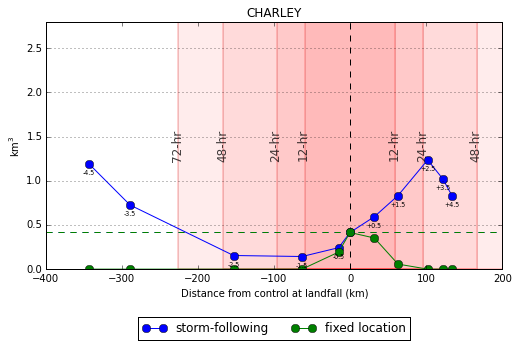

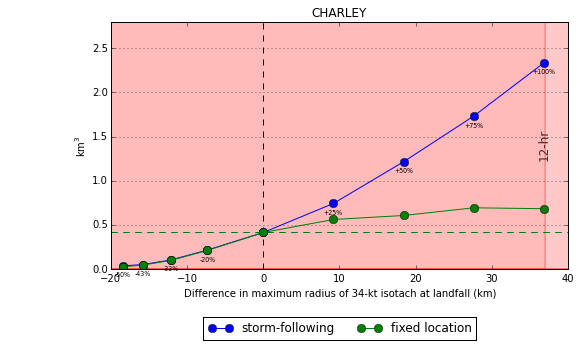

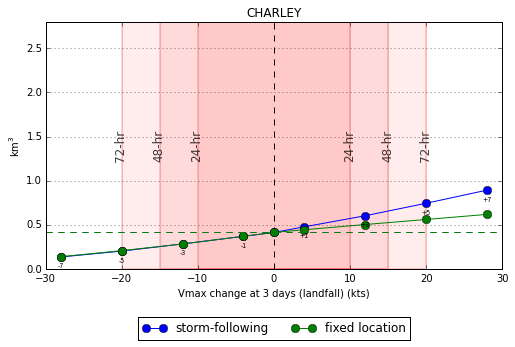

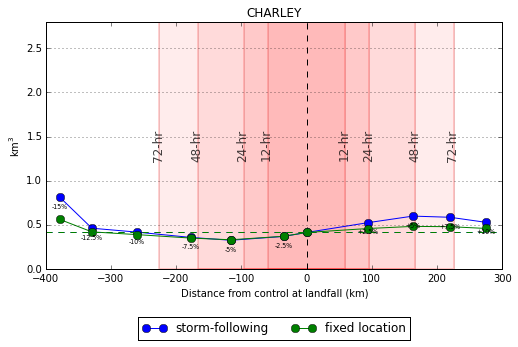

In [58]:
for perturbation in [veers, rmaxes, vmaxes, speeds]:
    if len(perturbation.values) == 0:
        print "no values for "+perturbation.name+" perturbation"
        continue

    fig, ax = plt.subplots(figsize=(7,4.))
    plt.tight_layout()

    storm_following_line, = ax.plot(perturbation.xticks,perturbation.max_vol, marker='o',label='storm-following')
    fixed_location_line, = ax.plot(perturbation.xticks,perturbation.max_vol_in_ctrl, marker='o',label='fixed location')
    plt.ylabel('$\mathregular{km^3}$')
    plt.title(perturbation.title)
    ax.set_xlabel(perturbation.xlabel)
    zeroLine(ax)
    forecast_err_boxes(ax, perturbation)
    ax.yaxis.grid()
    ax.set_ylim(0,2.8)
    if perturbation.storm.name == 'IKE':
        if perturbation == rmaxes or perturbation == vmaxes:
            ax.set_ylim(0,60.)
        else:
            ax.set_ylim(0,30.)
    
    # put legend to the right of the current axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.17), ncol=2, fontsize=12)
    # Label line with greater mean values    
    if np.mean(perturbation.max_vol) > np.mean(perturbation.max_vol_in_ctrl):
        annotate_pts(perturbation, storm_following_line)
    else:
        annotate_pts(perturbation, fixed_location_line)



    status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_maxvol.png', dpi=300)

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.veers_1.00m_pointA_maxvol.png dpi=125


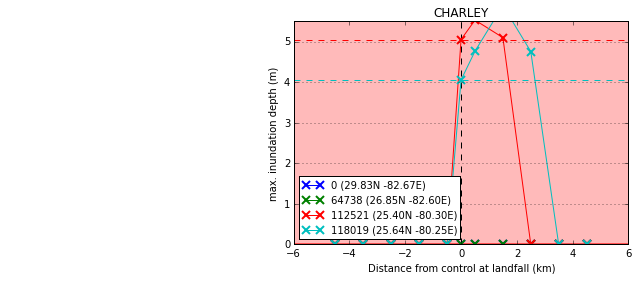

In [59]:
perturbation = veers
fig, ax = plt.subplots()
lines = ax.plot(perturbation.values,perturbation.pointA,marker='x',markeredgewidth=2)
#print perturbation.pointA, A
for i, line in enumerate(lines):
    plt.setp(line, label=str(A[i])+' (%.2fN ' % lat[i] + '%.2fE)' % lon[i])
plt.legend(loc='best',fontsize=10)
plt.title(thisstorm.name)
plt.xlabel(perturbation.xlabel)
zeroLine(ax)
forecast_err_boxes(ax, perturbation)

ax.yaxis.grid()
ax.set_ylim(0,5.5)
plt.ylabel('max. inundation depth (m)')
status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+perturbation.name+'_'+perturbation.Ithresh+'_pointA_maxvol.png')

created /glade/p/work/ahijevyc/ADCIRC/CHARLEY/CHARLEY.PointA.png dpi=125


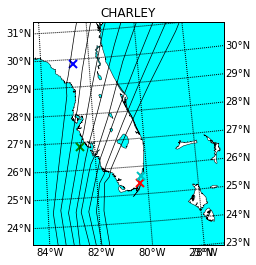

In [60]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots()
m = Basemap(lon_0=-90,lat_0=30,resolution='i',projection='stere',llcrnrlat=min(lat)-2,urcrnrlat=max(lat)+1,
            llcrnrlon=min(lon)-2,urcrnrlon=max(lon)+4)
m.drawcoastlines(linewidth=0.5)
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='white',lake_color='aqua')
#shp_info = m.readshapefile('/glade/p/work/ahijevyc/share/cb_2013_us_county_500k/cb_2013_us_county_500k',
#'cb_2013_us_county_500k')
ax.set_title(thisstorm.name)

# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(0.,81,1.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,True,False,True])
meridians = np.arange(10.,351.,2.)
m.drawmeridians(meridians,labels=[True,True,False,True])
x, y = m(lon,lat)
for i in np.arange(len(x)):
    m.plot(x[i],y[i],marker='x',linewidth=0,markeredgewidth=2)

tracks = '/glade/scratch/fossell/ADCIRC/IKE_RUN/nos_grid/v51_additive_perts/[cv]*[ly]/'
if thisstorm.name == 'CHARLEY': tracks = '/glade/p/work/ahijevyc/ADCIRC/CHARLEY/[cv][oe]*/'
for nc_file in glob.glob(tracks+'fort.22'):
    lat0, lon0 = np.genfromtxt(nc_file,delimiter=',', usecols=(6,7),dtype=None, unpack=True)
    lat0 = [int(i[:-1])/10. for i in lat0]
    lon0 = [int(i[:-1])/ -10. for i in lon0]
    x, y = m(lon0,lat0)
    m.plot(x, y,'black',label=nc_file[70:74],linewidth=(3 if 'control' in nc_file else .71))

status = mysavfig(perturbation.storm.basedir+perturbation.storm.name+'.'+'PointA.png')